# WAVE Client Data Analysis Example

This notebook demonstrates how to use the WAVE Python client to create and analyze experimental data.

## Prerequisites

1. **WAVE Backend**: Running at `http://localhost:8000`
2. **Dependencies**: Run `make setup-local-dev` and select the python kernel in `.venv`
3. **API Key**: Set `WAVE_API_KEY` in your `.env` file


## Setup

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from dotenv import load_dotenv
from wave_client import WaveClient

# Load environment variables
load_dotenv()
API_KEY = os.getenv('WAVE_API_KEY')
BASE_URL = os.getenv('WAVE_API_URL', 'http://localhost:8000')

if not API_KEY:
    raise ValueError("Please set WAVE_API_KEY in your .env file")

print(f"✓ Connecting to {BASE_URL}")

✓ Connecting to http://localhost:8000


In [2]:
# Initialize client and test connection
client = WaveClient(api_key=API_KEY, base_url=BASE_URL)

# Test connection
health = await client.get_health()
version = await client.get_version()

print(f"✓ Backend status: {health['status']}")
print(f"✓ API version: {version.get('api_version', 'unknown')}")

✓ Backend status: healthy
✓ API version: 1.0.0


## Create Sample Experiment and Data

In [3]:
# Create an experiment type first
try:
    exp_type = await client.experiment_types.create({
        "name": "Reaction Time Task",
        "table_name": "reaction_time_data",
        "description": "Simple reaction time measurement",
        "schema_definition": {
            "reaction_time": "FLOAT",
            "correct": "BOOLEAN", 
            "stimulus_type": "STRING",
            "trial_number": "INTEGER"
        }
    })
    exp_type_id = exp_type['id']
    print(f"✓ Created experiment type: {exp_type['name']} (ID: {exp_type_id})")
except Exception as e:
    print(f"Note: {e} (may already exist)")
    # Get existing experiment type
    exp_types = await client.experiment_types.list_as_dataframe()
    if len(exp_types) > 0:
        exp_type_id = exp_types.iloc[0]['id']
        print(f"✓ Using existing experiment type ID: {exp_type_id}")
    else:
        raise Exception("No experiment types available")

✓ Created experiment type: Reaction Time Task (ID: 1)


In [4]:
# Create a sample experiment
try:
    experiment = await client.experiments.create({
        "experiment_type_id": exp_type_id,
        "description": "Demonstration reaction time study",
        "tags": [],  # Empty tags to avoid dependency issues
        "additional_data": {"researcher": "notebook_demo"}
    })
    experiment_id = str(experiment['uuid'])  # Convert UUID to string
    print(f"✓ Created experiment: {experiment['description']} (ID: {experiment_id})")
except Exception as e:
    print(f"Note: {e} (may already exist)")
    # Get existing experiment
    experiments = await client.experiments.list_as_dataframe()
    if len(experiments) > 0:
        experiment_id = str(experiments.iloc[0]['uuid'])  # Convert UUID to string
        print(f"✓ Using existing experiment ID: {experiment_id}")
    else:
        raise Exception("No experiments available")

✓ Created experiment: Demonstration reaction time study (ID: f7fdc16f-8da6-4fbe-8151-d0731e3822ea)


In [5]:
# Generate sample data for 3 participants with 20 trials each
participants = ['P001', 'P002', 'P003']
stimuli = ['visual', 'auditory']

print("Creating sample data...")

for participant_id in participants:
    for trial in range(1, 21):  # 20 trials per participant
        # Generate realistic reaction time data
        base_rt = np.random.normal(0.8, 0.2)  # Mean 800ms, SD 200ms
        if base_rt < 0.2:
            base_rt = 0.2  # Minimum realistic RT
        
        stimulus = np.random.choice(stimuli)
        correct = np.random.choice([True, False], p=[0.85, 0.15])  # 85% accuracy
        
        trial_data = {
            "reaction_time": float(round(base_rt, 3)),  # Convert to Python float
            "correct": bool(correct),  # Convert to Python bool
            "stimulus_type": str(stimulus),  # Convert to Python str
            "trial_number": int(trial)  # Convert to Python int
        }
        
        # Use the correct API structure: participant_id and data as separate fields
        await client.experiment_data.create(
            experiment_id, 
            {
                "participant_id": participant_id,
                "data": trial_data
            }
        )

print(f"✓ Created 60 data points for {len(participants)} participants")

Creating sample data...
✓ Created 60 data points for 3 participants
✓ Created 60 data points for 3 participants


## Retrieve and Display Data

In [6]:
# Get all experiment data
data_df = await client.experiment_data.get_all_data(experiment_id=experiment_id)
print(f"Retrieved {len(data_df)} data points")

# Display the data
display(data_df)

Retrieved 60 data points


,id,experiment_uuid,participant_id,created_at,updated_at,reaction_time,correct,stimulus_type,trial_number
0,60,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.225721,2025-08-06 17:08:02.225721,0.715,True,auditory,20
1,59,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.208629,2025-08-06 17:08:02.208629,0.649,True,auditory,19
2,58,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.190908,2025-08-06 17:08:02.190908,0.755,True,visual,18
3,57,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.173519,2025-08-06 17:08:02.173519,0.448,False,visual,17
4,56,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.156240,2025-08-06 17:08:02.156240,0.629,True,auditory,16
5,55,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.137901,2025-08-06 17:08:02.137901,0.840,True,visual,15
6,54,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.119478,2025-08-06 17:08:02.119478,0.653,True,visual,14
7,53,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.102140,2025-08-06 17:08:02.102140,0.815,True,auditory,13
8,52,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.083344,2025-08-06 17:08:02.083344,1.000,True,auditory,12
9,51,f7fdc16f-8da6-4fbe-8151-d0731e3822ea,P003,2025-08-06 17:08:02.066033,2025-08-06 17:08:02.066033,0.780,True,auditory,11


In [7]:
# Basic statistics
print("Basic Statistics:")
print(f"Mean reaction time: {data_df['reaction_time'].mean():.3f} seconds")
print(f"Overall accuracy: {data_df['correct'].mean():.1%}")
print(f"Participants: {data_df['participant_id'].nunique()}")

# Descriptive statistics for numeric columns
display(data_df[['reaction_time']].describe())

Basic Statistics:
Mean reaction time: 0.790 seconds
Overall accuracy: 88.3%
Participants: 3


,reaction_time
count,60.000000
mean,0.790250
std,0.215405
min,0.316000
25%,0.652000
50%,0.787500
75%,0.933750
max,1.283000


## Simple Visualization

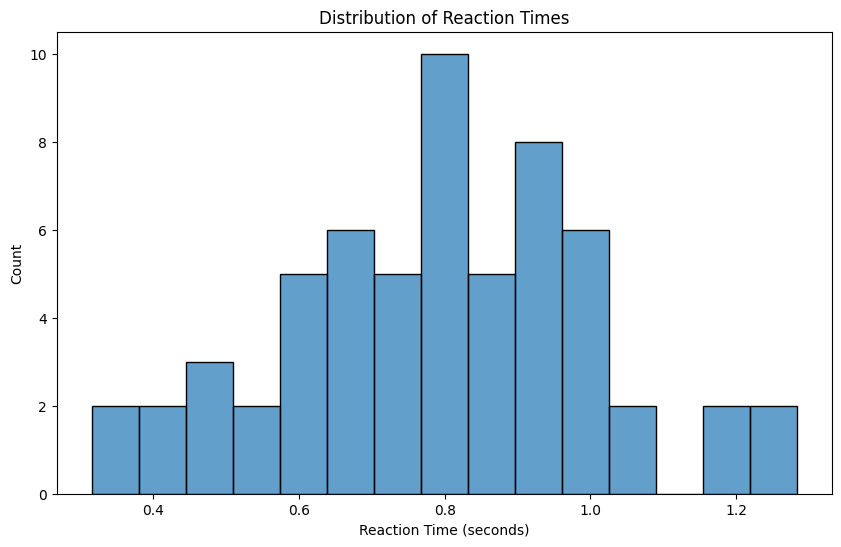

In [8]:
# Create a simple histogram of reaction times
plt.figure(figsize=(10, 6))
sns.histplot(data=data_df, x='reaction_time', bins=15, alpha=0.7)
plt.title('Distribution of Reaction Times')
plt.xlabel('Reaction Time (seconds)')
plt.ylabel('Count')
plt.show()

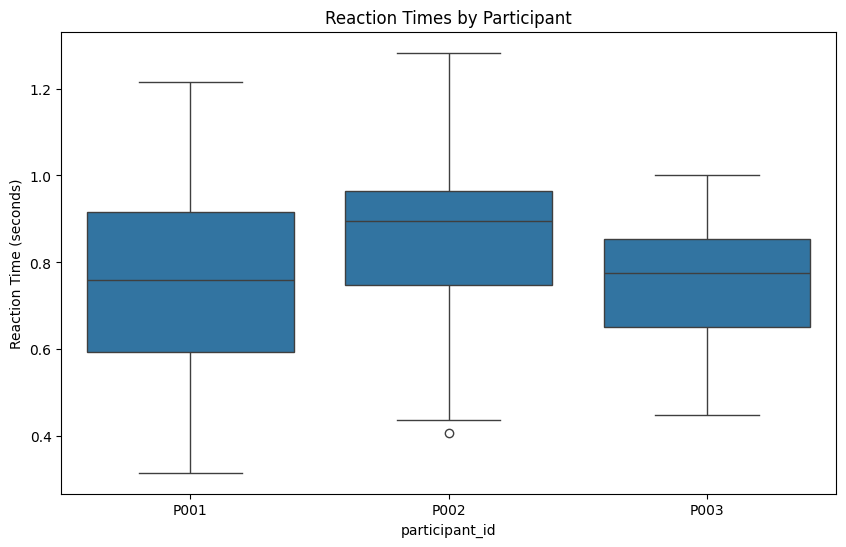

In [9]:
# Reaction times by participant
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df, x='participant_id', y='reaction_time')
plt.title('Reaction Times by Participant')
plt.ylabel('Reaction Time (seconds)')
plt.show()

## Participant-Level Analysis

In [10]:
# Aggregate by participant
participant_summary = data_df.groupby('participant_id').agg({
    'reaction_time': ['count', 'mean', 'std'],
    'correct': 'mean'
}).round(3)

# Flatten column names
participant_summary.columns = ['trials', 'rt_mean', 'rt_std', 'accuracy']
participant_summary = participant_summary.reset_index()

print("Participant Summary:")
display(participant_summary)

Participant Summary:


/var/folders/b9/by4645sj1qs3zlbv_gjj27_c0000gp/T/ipykernel_11724/4211253600.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  participant_summary = data_df.groupby('participant_id').agg({


,participant_id,trials,rt_mean,rt_std,accuracy
0,P001,20,0.751,0.245,0.90
1,P002,20,0.854,0.235,0.90
2,P003,20,0.766,0.149,0.85


## Search and Filter Examples

In [11]:
# Filter data examples
print("Data filtering examples:")

# Fast responses (< 700ms)
fast_responses = data_df[data_df['reaction_time'] < 0.7]
print(f"Fast responses (< 0.7s): {len(fast_responses)} trials")

# Correct responses only
correct_only = data_df[data_df['correct'] == True]
print(f"Correct responses: {len(correct_only)} trials")

# Participant P001 data
p001_data = data_df[data_df['participant_id'] == 'P001']
print(f"P001 data: {len(p001_data)} trials")

# Visual stimulus trials
visual_trials = data_df[data_df['stimulus_type'] == 'visual']
print(f"Visual stimulus trials: {len(visual_trials)} trials")

Data filtering examples:
Fast responses (< 0.7s): 20 trials
Correct responses: 53 trials
P001 data: 20 trials
Visual stimulus trials: 33 trials


In [12]:
# Search experiments
all_experiments = await client.experiments.list_as_dataframe()
display(all_experiments)

,description,tags,additional_data,uuid,experiment_type_id,created_at,updated_at,type_name,type_description,type_table_name,type_schema_definition,type_id,type_created_at,type_updated_at
0,Demonstration reaction time study,[],{'researcher': 'notebook_demo'},f7fdc16f-8da6-4fbe-8151-d0731e3822ea,1,2025-08-06 17:08:00.887433+00:00,2025-08-06 17:08:00.887433+00:00,Reaction Time Task,Simple reaction time measurement,reaction_time_data,"{'reaction_time': 'FLOAT', 'correct': 'BOOLEAN...",1,2025-08-06 17:08:00.840309+00:00,2025-08-06 17:08:00.840309+00:00


## Clean Up

## Delete Experiment Data

Clean up by deleting the experiment and experiment type created for this demo.

Deleting data requires an Admin level API key

In [ ]:
# Delete experiment data first
print("Deleting experiment data...")
try:
    # Get all data rows to delete them individually
    all_data = await client.experiment_data.get_all_data(experiment_id)
    
    if len(all_data) > 0:
        deleted_count = 0
        for _, row in all_data.iterrows():
            try:
                await client.experiment_data.delete_row(experiment_id, int(row['id']))
                deleted_count += 1
            except Exception as e:
                print(f"  Failed to delete row {row['id']}: {e}")
        
        print(f"✓ Deleted {deleted_count} experiment data rows")
    else:
        print("✓ No experiment data to delete")
        
except Exception as e:
    print(f"Note: Could not delete experiment data: {e}")

# Now delete the experiment
try:
    delete_response = await client.experiments.delete(experiment_id)
    print(f"✓ Deleted experiment: {experiment_id}")
    print(f"  Response: {delete_response.get('message', 'Success')}")
except Exception as e:
    print(f"Note: Could not delete experiment: {e}")

# Optionally, also delete the experiment type if it was created for this demo
try:
    delete_type_response = await client.experiment_types.delete(exp_type_id)
    print(f"✓ Deleted experiment type: {exp_type_id}")
    print(f"  Response: {delete_type_response.get('message', 'Success')}")
except Exception as e:
    print(f"Note: Could not delete experiment type: {e}")

Deleting experiment data...
✓ Deleted 60 experiment data rows
✓ Deleted experiment: f7fdc16f-8da6-4fbe-8151-d0731e3822ea
  Response: Experiment deleted successfully
✓ Deleted experiment type: 1
  Response: Experiment type deleted successfully
✓ Deleted 60 experiment data rows
✓ Deleted experiment: f7fdc16f-8da6-4fbe-8151-d0731e3822ea
  Response: Experiment deleted successfully
✓ Deleted experiment type: 1
  Response: Experiment type deleted successfully


In [14]:
all_experiments = await client.experiments.list_as_dataframe()
display(all_experiments)

""


In [15]:
# # Close client connection
# await client.close()
# print("✓ Client connection closed")